In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import iplot

import warnings
warnings.filterwarnings('ignore')

carrie1_ecommerce_data_path = kagglehub.dataset_download('carrie1/ecommerce-data')

## Setup and Initialization

## Initial Data Analysis

In [143]:
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### **Dataset Description:**

The dataset consist of 541,909 entries and 8 columns.

| **Column**    | **Description**                                                                                   |
|----------------|---------------------------------------------------------------------------------------------------|
| Invoice        | Code representing each unique transaction. If this code starts with letter 'C', it indicates a cancellation. |
| StockCode      | Code uniquely assigned to each distinct product.                                                  |
| Description    | Description of each product.                                                                      |
| Quantity       | The number of units of a product in a transaction.                                                |
| InvoiceDate    | The date and time of the transaction.                                                             |
| UnitPrice          | The unit price of the product in sterling.                                                        |
| Customer ID     | Identifier uniquely assigned to each customer.                                                   |
| Country        | The country where each transaction took place.                                                   |


## Data Cleaning and Transformation

### Handling Missing Values

In [145]:
missing_percentage = df[['CustomerID', 'Description']].isnull() \
    .mean() * 100

missing_percentage

,0
CustomerID,24.926694
Description,0.268311


Both columns are essential for clustering customers. Therefore, missing values in the dataset are removed.

In [146]:
df.dropna(inplace = True)

### Handling Duplicates

In [147]:
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")
df.drop_duplicates(inplace = True)
df.info()

The dataset contains 5225 duplicate rows that need to be removed.
<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


### Identifying Stock Codes

Number of unique StockCodes: 3684


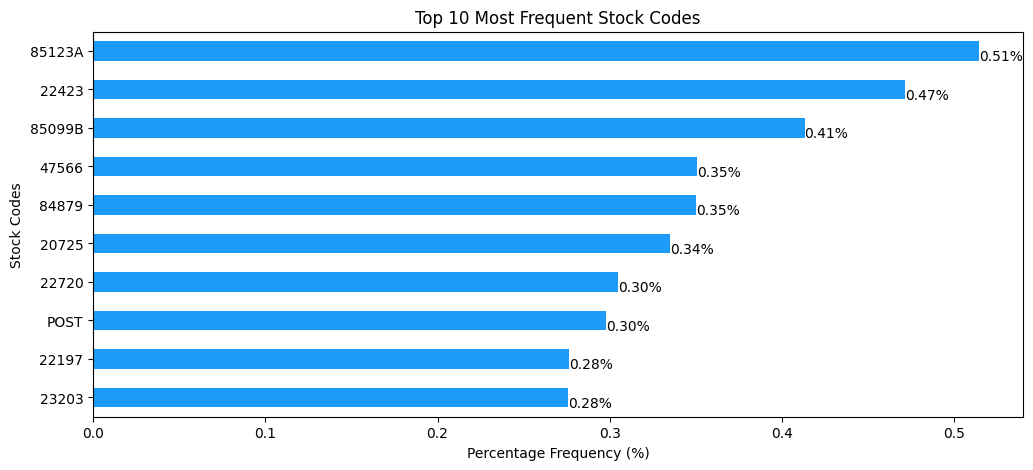

In [148]:

nunique_stock_codes = df['StockCode'].nunique()
print(f"Number of unique StockCodes: {nunique_stock_codes}")

top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100


plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#1C9BF9')

for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

 The dataset contains 3684 unique stock codes. This diversity can potentially lead to the identification of distinct customers clusters, with preferences for different types of products.
 A closer look at the top 10 most frequent stock codes can offer insights into the popular products or categories that are frequently purchased by customers.

In [149]:
# Anomalous stock codes

unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()
numeric_char_counts_in_unique_codes
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

for code in anomalous_stock_codes:
    print(code)

POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [150]:
percentage_anomalous_stock_codes = len(df[df['StockCode'].isin(anomalous_stock_codes)]) / len(df) * 100
print(f"Percentage of records with anomalous stock codes: {percentage_anomalous_stock_codes:.2f}%")

Percentage of records with anomalous stock codes: 0.48%


We observe that while most stock codes are composed of 5 or 6 characters, there are some anomalies like the code 'BANK CHANGES', 'POST' (perhaps postage fees) These anomalies might represent services or non-product transactions rather than actual products.

Only 0.48%, have anomalous stock codes, which deviate from the typical format observed in the majority of the data.

We remove the anomalous stock codes since there's a negligible amount of stock codes

In [151]:
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

len(df)

399689

### Handling Cancelled Transactions

In [152]:
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop(['CustomerID'], axis=1)

,Quantity,UnitPrice
count,8506.000000,8506.000000
mean,-31.473195,4.440148
std,1197.051599,9.199140
min,-80995.000000,0.030000
25%,-6.000000,1.450000
50%,-2.000000,2.550000
75%,-1.000000,4.950000
max,-1.000000,295.000000


In [153]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print(f'Shape of transactions with TotalPrice negative: {df[df["TotalPrice"] < 0].shape}')

print(f'Sum of TotalPrice with negative values: {df[df["TotalPrice"] < 0]["TotalPrice"].sum()}')


print(f'Sum of TotalPrice with Transaction_Status as Cancelled: {df[df["Transaction_Status"] == "Cancelled"]["TotalPrice"].sum()}')

cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100
print(f'Cancelled transactions percentage : {cancelled_percentage}')

Shape of transactions with TotalPrice negative: (8506, 10)
Sum of TotalPrice with negative values: -471750.71
Sum of TotalPrice with Transaction_Status as Cancelled: -471750.71
Cancelled transactions percentage : 2.128154640232781


We can see that even thought the percentage of cancelled transactions is low, the total money is signiflicantly high.

The strategy is to retain these cancelled transactions in the dataset, marking them distinctly to facilitate further analysis. This approach will:

- Enhance feature engineering metrics.
- The sum of total spend by customer will be balanced with the transaction of order in the first place.
- Identify products with high cancellation rating.

### Cleaning Description Column

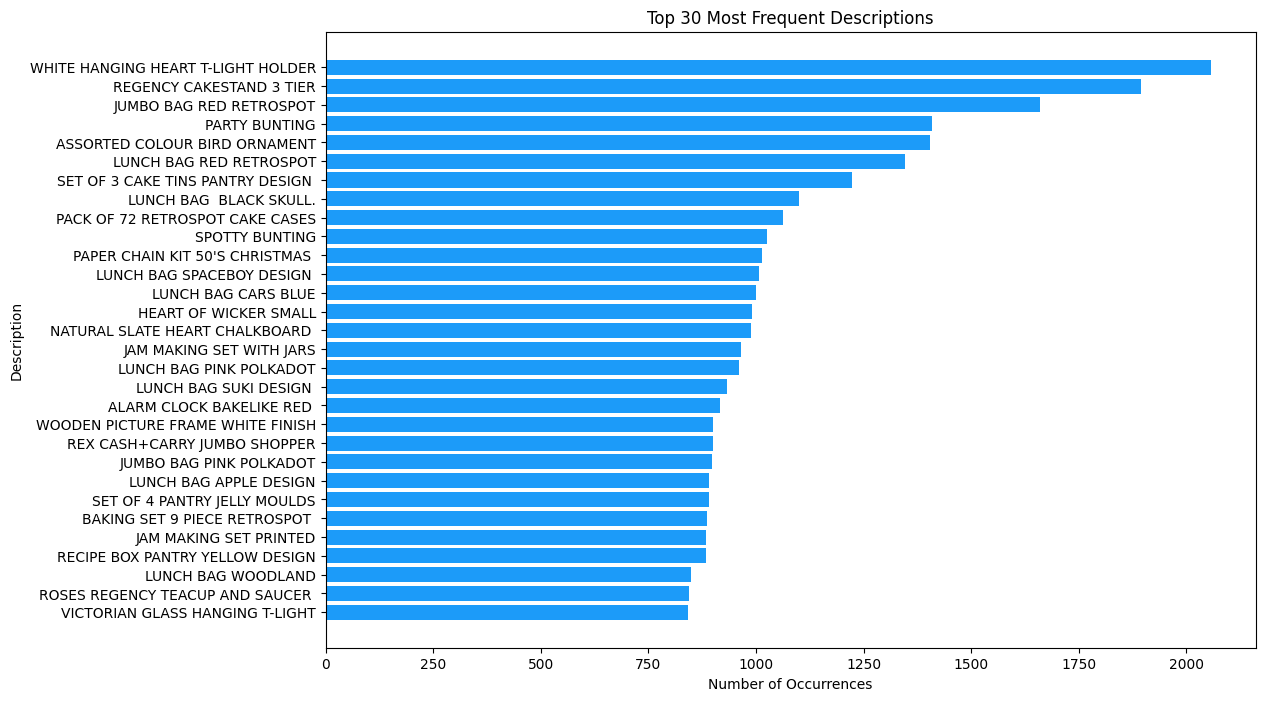

In [154]:
description_counts = df['Description'].value_counts()

top_30_descriptions = description_counts[:30]

plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#1C9BF9')

plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

plt.show()

In [155]:
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(c.islower() for c in str(desc))]

print("Unique descriptions containing lowercase letters:")
print("-" * 50)
for desc in lowercase_descriptions:
    print(desc)

Unique descriptions containing lowercase letters:
--------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [156]:
service_descriptions = ["Next Day Carriage", "High Resolution Image"]

number_service_descriptions = df[df['Description'].isin(service_descriptions)].shape[0]
percentage_service_descriptions = (number_service_descriptions / df.shape[0]) * 100
print(f"Number of records with service descriptions: {number_service_descriptions}")
print(f"Percentage of records with service descriptions: {percentage_service_descriptions:.2f}%")

df = df[~df['Description'].isin(service_descriptions)]

Number of records with service descriptions: 83
Percentage of records with service descriptions: 0.02%


In [157]:
df.shape[0]

399606

### Inferences

- The most frequent descriptions are generally household items, particularly those associated with kitchenware, lunch bags, and decorative items.

- All the descriptions are in uppercase, which might be a standardized format for entering product descriptions in the database. It would be prudent to check if there are descriptions entered in lowercase or a mix of case styles.

- Upon reviewing the descriptions that contain lowecase characters, it is evident that some entries are not product descriptions, such as "Next Day Carriage" and "High Resolution Image". Therefore, we removed rows with this descriptions.

## Comparing Stock Codes with Descriptions

In [158]:
{columns: len(df[columns].unique()) for columns in df.columns}

{'InvoiceNo': 21784,
 'StockCode': 3674,
 'Description': 3886,
 'Quantity': 432,
 'InvoiceDate': 20132,
 'UnitPrice': 370,
 'CustomerID': 4363,
 'Country': 37,
 'Transaction_Status': 2,
 'TotalPrice': 3756}

In [159]:
df['StockCode'] = df['StockCode'].astype(str)
df['Description'] = df['Description'].astype(str)

description_counts = df.groupby('Description')['StockCode'].nunique().reset_index()
description_counts.rename(columns={'StockCode': 'StockCode_Count'}, inplace=True)

shared_descriptions = description_counts[description_counts['StockCode_Count'] > 1]

print("Descriptions shared by multiple StockCodes:")
print("-" * 50)
print(shared_descriptions)

shared_desc_details = df[df['Description'].isin(shared_descriptions['Description'])][['StockCode', 'Description']].drop_duplicates().sort_values(by='Description')

print("\nStockCode details with shared descriptions:")
print("-" * 50)
print(shared_desc_details)

Descriptions shared by multiple StockCodes:
--------------------------------------------------
                          Description  StockCode_Count
827      COLOURING PENCILS BROWN TUBE                2
829        COLUMBIAN CANDLE RECTANGLE                2
830            COLUMBIAN CANDLE ROUND                2
1080  EAU DE NILE JEWELLED PHOTOFRAME                2
1324     FRENCH FLORAL CUSHION COVER                 2
1327    FRENCH LATTICE CUSHION COVER                 2
1345              FROSTED WHITE BASE                 2
2018   METAL SIGN,CUPCAKE SINGLE HOOK                3
2332  PAPER LANTERN 9 POINT SNOW STAR                2
2461    PINK FAIRY CAKE CUSHION COVER                2
2466    PINK FLOCK GLASS CANDLEHOLDER                2
2472       PINK FLOWERS RABBIT EASTER                2
2796          RETRO PLASTIC 70'S TRAY                2
2797         RETRO PLASTIC DAISY TRAY                2
2799         RETRO PLASTIC POLKA TRAY                2
2872     ROUND BLUE CLOCK

In [160]:
df['StockCode'] = df['StockCode'].astype(str)

stock_code_description = df.groupby('StockCode')['Description'].nunique().reset_index()
stock_code_description.rename(columns={'Description': 'Unique_Descriptions_Count'}, inplace= True)

multiple_descriptions = stock_code_description[stock_code_description['Unique_Descriptions_Count'] > 1]

print("Stock codes with more than 1 unique description:")
print("-" * 50)

print(multiple_descriptions)

multiple_descriptions_details = multiple_descriptions['StockCode']
details = df[df['StockCode'].isin(multiple_descriptions_details)][['StockCode', 'Description']].drop_duplicates().sort_values(by='StockCode')

print("\nDetails of the stock codes with more than 1 unique description:")
print("-" * 50)
print(details)

Stock codes with more than 1 unique description:
--------------------------------------------------
     StockCode  Unique_Descriptions_Count
42      16156L                          2
100     17107D                          3
118      20622                          2
170      20725                          2
262      20914                          2
...        ...                        ...
3308    85184C                          2
3309    85185B                          2
3372    90014A                          2
3373    90014B                          2
3374    90014C                          2

[213 rows x 2 columns]

Details of the stock codes with more than 1 unique description:
--------------------------------------------------
       StockCode                          Description
47284     16156L                       WRAP, CAROUSEL
138080    16156L                        WRAP CAROUSEL
315743    17107D         FLOWER FAIRY 5 DRAWER LINERS
347764    17107D    FLOWER FAIRY 5 SUMME

In [161]:
{columns: len(df[columns].unique()) for columns in df.columns}

{'InvoiceNo': 21784,
 'StockCode': 3674,
 'Description': 3886,
 'Quantity': 432,
 'InvoiceDate': 20132,
 'UnitPrice': 370,
 'CustomerID': 4363,
 'Country': 37,
 'Transaction_Status': 2,
 'TotalPrice': 3756}

In [162]:

df['StockCode'] = df['StockCode'].astype(str)
df['Description'] = df['Description'].astype(str)

most_frequent_desc = df.groupby(['StockCode', 'Description']).size().reset_index(name='Count')
most_frequent_desc = most_frequent_desc.sort_values(['StockCode', 'Count'], ascending=[True, False])
most_frequent_desc = most_frequent_desc.groupby('StockCode').first().reset_index()[['StockCode', 'Description']]

df = df.drop(columns=['Description']).merge(most_frequent_desc, on='StockCode', how='left')

description_counts = df.groupby('Description')['StockCode'].nunique().reset_index()
shared_descriptions = description_counts[description_counts['StockCode'] > 1]['Description']

df.loc[df['Description'].isin(shared_descriptions), 'Description'] = (
    df['Description'] + " (" + df['StockCode'] + ")"
)


print("Unique values after cleaning:")
print(f"StockCode: {df['StockCode'].nunique()}")
print(f"Description: {df['Description'].nunique()}")

stock_code_description = df.groupby('StockCode')['Description'].nunique().reset_index()
multiple_descriptions = stock_code_description[stock_code_description['Description'] > 1]
if multiple_descriptions.empty:
    print("No StockCode with multiple descriptions.")
else:
    print("Warning: Some StockCode still have multiple descriptions:")
    print(multiple_descriptions)

# Check shared descriptions
description_counts = df.groupby('Description')['StockCode'].nunique().reset_index()
shared_descriptions = description_counts[description_counts['StockCode'] > 1]
if shared_descriptions.empty:
    print("There are no descriptions shared by multiple StockCode.")
else:
    print("Warning: Some descriptions are still shared:")
    print(shared_descriptions)

Unique values after cleaning:
StockCode: 3674
Description: 3674
No StockCode with multiple descriptions.
There are no descriptions shared by multiple StockCode.


### Inferences:

- **StockCodes with multiple Descriptions:** 213 StockCodes have multiple descriptions (196 with 2, 15 with 3, 2 with 4), causing extra Description values
- **Descriptions shared by multiple StockCodes:** 19 descriptions are used by 39 StockCodes

The presence of multiple descriptions per StockCode and shared descriptions across StockCode led to data quality issues, complicating product-level analyses such as identifying top-selling items.

### Strategy:

- For the 213 StockCodes with multiple descriptions, we selected the most frequent Description for each StockCode using a group-by operation and sorting by count.
- For the 19 descriptions shared across 39 StockCode, we appended the StockCode in parentheses to create unique descriptions (e.g., "COLOURING PENCILS BROWN TUBE (10133)" and "COLOURING PENCILS BROWN TUBE (10135)").

## Treating Zero Unit Prices

###

In [163]:
df['UnitPrice'].describe()

,UnitPrice
count,399606.000000
mean,2.904957
std,4.448796
min,0.000000
25%,1.250000
50%,1.950000
75%,3.750000
max,649.500000


In [164]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [165]:
df[df['UnitPrice']==0].head(10)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status,TotalPrice,Description
6816,537197,22841,1,12/5/2010 14:02,0.0,12647.0,Germany,Completed,0.0,ROUND CAKE TIN VINTAGE GREEN
22536,539263,22580,4,12/16/2010 14:36,0.0,16560.0,United Kingdom,Completed,0.0,ADVENT CALENDAR GINGHAM SACK
25442,539722,22423,10,12/21/2010 13:45,0.0,14911.0,EIRE,Completed,0.0,REGENCY CAKESTAND 3 TIER
29243,540372,22090,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,Completed,0.0,PAPER BUNTING RETROSPOT
29245,540372,22553,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,Completed,0.0,PLASTERS IN TIN SKULLS
34743,541109,22168,1,1/13/2011 15:10,0.0,15107.0,United Kingdom,Completed,0.0,ORGANISER WOOD ANTIQUE WHITE
54228,543599,84535B,16,2/10/2011 13:08,0.0,17560.0,United Kingdom,Completed,0.0,FAIRY CAKES NOTEBOOK A6 SIZE
86338,547417,22062,36,3/23/2011 10:25,0.0,13239.0,United Kingdom,Completed,0.0,CERAMIC BOWL WITH LOVE HEART DESIGN
93491,548318,22055,5,3/30/2011 12:45,0.0,13113.0,United Kingdom,Completed,0.0,MINI CAKE STAND HANGING STRAWBERY
98139,548871,22162,2,4/4/2011 14:42,0.0,14410.0,United Kingdom,Completed,0.0,HEART GARLAND RUSTIC PADDED


In [166]:
df = df[df['UnitPrice'] > 0]

In [167]:
df.reset_index(drop=True, inplace=True)
df.shape[0]

399573

### Inferences

- The transactions with a unit price of zero are relatively few in number (33 transactions).
- These transactions have a large variability in the quantity of items involved, ranging from 1 to 12540, with a substantial standard deviation.

Given the small number of these transactions and their potential to introduce noise in the data analysis, the strategy should be to remove these transactions from the dataset.

# Feature Engineering

In [168]:
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status,TotalPrice,Description
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Completed,15.30,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed,20.34,WHITE METAL LANTERN
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Completed,22.00,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed,20.34,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed,20.34,RED WOOLLY HOTTIE WHITE HEART.


In [169]:
print("Min Date", df["InvoiceDate"].min(), "Max Date", df["InvoiceDate"].max())

Min Date 1/10/2011 10:32 Max Date 9/9/2011 9:52


## Customer Behavioral Features (RFM)

### Recency

This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.

In [170]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

today_date = df.agg({"InvoiceDate":"max"})

customer_data = (today_date - df.groupby("CustomerID") \
           .agg({"InvoiceDate":"max"})) \
            .rename(columns = {"InvoiceDate":"Recency"})

customer_data["Recency"] = customer_data["Recency"] \
    .apply(lambda x: x.days)

customer_data.head()

,Recency
CustomerID,
12346.0,325
12347.0,1
12348.0,74
12349.0,18
12350.0,309


### Frecuency

There are two features that quantify the frequency of a customer's engagement with the retailer:

- **Total Transactions:** This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.

- **Total Products Purchased:** This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.

In [171]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'] \
                    .nunique() \
                        .reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

total_products_purchased = df.groupby('CustomerID')['Quantity'] \
                            .sum() \
                                .reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Recency,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,1,7,2458
2,12348.0,74,4,2332
3,12349.0,18,1,630
4,12350.0,309,1,196


### Monetary

There are two features that represent the monetary aspect of customer's transactions:

- **Total Spend:** This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.

- **Average Transaction Value:** This feature is calculated as the **Total Spend** divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.

In [172]:
total_spend = df.groupby('CustomerID')['TotalPrice'] \
            .sum() \
                .reset_index()

total_spend.rename(columns={'TotalPrice': 'Total_Spend'}, inplace=True)

average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,1,7,2458,4310.00,615.714286
2,12348.0,74,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,309,1,196,294.40,294.400000


In [173]:
unique_products_purchased = df.groupby('CustomerID')['StockCode'] \
                            .nunique() \
                                .reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,1,7,2458,4310.00,615.714286,103
2,12348.0,74,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,309,1,196,294.40,294.400000,16


## Cancellation Insights

- **Cancellation Frequency:** This metric represents the total number of transactions a customer has canceled. Understanding the frequency of cancellations can help us identify customers who are more likely to cancel transactions. This could be an indicator of dissatisfaction or other issues, and understanding this can help us tailor strategies to reduce cancellations and enhance customer satisfaction.

- **Cancellation Rate:** This represents the proportion of transactions that a customer has canceled out of all their transactions. This metric gives a normalized view of cancellation behavior. A high cancellation rate might be indicative of an unsatisfied customer segment. By identifying these segments, we can develop targeted strategies to improve their shopping experience and potentially reduce the cancellation rate.

In [174]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

customer_data.head()

,CustomerID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,1.0,0.5
1,12347.0,1,7,2458,4310.00,615.714286,103,0.0,0.0
2,12348.0,74,4,2332,1437.24,359.310000,21,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.0,0.0
4,12350.0,309,1,196,294.40,294.400000,16,0.0,0.0


In [175]:
customers_who_cancelled = customer_data[customer_data['Cancellation_Rate'] > 0]
print(f"Number of customers who cancelled at least one transaction: {customers_who_cancelled.shape[0]}")
customers_who_cancelled.head(15)

Number of customers who cancelled at least one transaction: 1534


,CustomerID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,1.0,0.500000
5,12352.0,35,8,463,1265.41,158.176250,57,1.0,0.125000
12,12359.0,7,6,1599,6182.98,1030.496667,214,2.0,0.333333
15,12362.0,2,13,2180,4665.58,358.890769,200,3.0,0.230769
25,12375.0,2,3,175,375.42,125.140000,13,1.0,0.333333
28,12379.0,81,3,401,775.29,258.430000,38,1.0,0.333333
29,12380.0,21,5,1109,2423.56,484.712000,76,1.0,0.200000
30,12381.0,4,4,772,1433.46,358.365000,69,1.0,0.250000
31,12383.0,184,6,1515,1617.31,269.551667,83,1.0,0.166667
32,12384.0,28,3,117,406.16,135.386667,25,1.0,0.333333


## Seasonality

The seasonality in customers' purchasing behaviors can offer invaluable insights for tailoring marketing strategies and enhancing customer satisfaction. Here are the two features to introduce:

- **Monthly_Spending_Mean:** This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer. A higher mean indicates a customer who spends more, potentially showing interest in premium products, whereas a lower mean might indicate a more budget-conscious customer.

- **Monthly_Spending_Std:** This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases. In contrast, a lower value suggests more stable, consistent spending habits. Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend more.

In [176]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['TotalPrice'].sum().reset_index()

seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['TotalPrice'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

df.drop(columns=['Year', 'Month'], inplace=True)

In [177]:
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')

customer_data.head()

,CustomerID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std
0,12346.0,325,2,0,0.00,0.000000,1,1.0,0.5,0.000000,0.000000
1,12347.0,1,7,2458,4310.00,615.714286,103,0.0,0.0,615.714286,341.070789
2,12348.0,74,4,2332,1437.24,359.310000,21,0.0,0.0,359.310000,203.875689
3,12349.0,18,1,630,1457.55,1457.550000,72,0.0,0.0,1457.550000,0.000000
4,12350.0,309,1,196,294.40,294.400000,16,0.0,0.0,294.400000,0.000000


## Customer Dataset Description

| **Column**                    | **Description**                                                                                      |
|-------------------------------|------------------------------------------------------------------------------------------------------|
| Customer ID                   | Identifier uniquely assigned to each customer, used to distinguish individual customers.             |
| Recency                       | The number of days that have passed since the customer's last purchase.                             |
| Total_Transactions            | The total number of transactions made by the customer.                                              |
| Total_Products_Purchased      | The total quantity of products purchased by the customer across all transactions.                   |
| Total_Spend                   | The total amount of money the customer has spent across all transactions.                           |
| Average_Transaction_Value     | The average value of the customer's transactions, calculated as total spend divided by transactions. |
| Unique_Products_Purchased     | The number of different products the customer has purchased.                                        |
| Cancellation_Frequency        | The total number of transactions that the customer has cancelled.                                   |
| Cancellation_Rate             | The proportion of transactions that the customer has cancelled, calculated as cancellations/total.  |
| Monthly_Spending_Mean         | The average monthly spending of the customer.                                                       |
| Monthly_Spending_Std          | The standard deviation of the customer's monthly spending, indicating variability.                  |


## Correlation Analysis

Before we proceed to KMeans clustering, it's essential to check the correlation between features in our dataset.

In [178]:
from plotly import express as px

customer_data_cleaned = customer_data.copy()

corr = customer_data_cleaned.drop(columns=['CustomerID']).corr().round(2)

mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
corr_masked = corr.mask(mask)

fig = px.imshow(
    corr_masked,
    text_auto=True,
    color_continuous_scale=["#ffffff", "#1C9BF9"],
    aspect="equal",
    labels=dict(x="", y="", color="Correlation")
)

fig.update_layout(
    width=900,
    height=900,
    xaxis_side="bottom",
    font=dict(size=15),
    xaxis=dict(tickfont=dict(family="Arial", size=14)),
    yaxis=dict(tickfont=dict(family="Arial", size=14))
)


fig.update_traces(
    textfont=dict(family="Arial", size=18),
    texttemplate="%{z:.2f}"
)

fig.update_xaxes(tickangle=270)

fig.show()


- **Recency:** The more recent the customer’s last purchase, the more transactions (-0.26), products (-0.14), and money (-0.13) they spent. A shorter recency is associated with higher engagement, and customers who returned recently also bought a wider variety of products (-0.30).
- **Total_Transactions:** More transactions are tied to more products purchased (0.57), higher total spending (0.55), a wider range of items (0.70), and a higher frequency of cancellations (0.79). Frequent customers tend to be high spenders who explore more products and are also more likely to cancel.
- **Total_Products_Purchased:** Buying more products correlates strongly with total spend (0.92), showing that product quantity drives revenue. It’s also linked to greater variety (0.44), more transactions (0.57), and slightly with more cancellations (0.35).
- **Total_Spend:** Strongly tied to product volume (0.92) and both average (0.73) and variance (0.82) monthly spending. High spenders also transact more (0.55). This is the clearest indicator of high-value customers.
- **Average_Transaction_Value:** Closely associated with average monthly spending (0.79) and moderately with total spend (0.44). This feature reflects purchasing power per transaction, but has minimal correlation with frequency or recency.
- **Unique_Products_Purchased:** A wider range of products is linked to more transactions (0.70), total spend (0.40), and product count (0.44). These customers tend to cancel slightly more (0.53) and have made more recent purchases (-0.30).
- **Cancellation_Frequency:** More frequent cancellations correlate with product variety (0.53), total product count (0.35), and number of transactions (0.35). These customers are active but may have issues with satisfaction. They also tend to have bought more recently (-0.19).
- **Cancellation_Rate:** Only moderately associated with cancellation frequency (0.45), and largely independent of recency (-0.01), spend (0.03), or transaction volume. It likely reflects a behavioral pattern not directly tied to purchase value.
- **Monthly_Spending_Mean:** Strongly correlated with total spend (0.73), transaction value (0.79), and product quantity (0.62). This metric reflects stable, high-value customer behavior and a pattern of regular spending.
- **Monthly_Spending_Std:** High variability in monthly spending correlates with higher overall spending (0.82), higher monthly average (0.66), and slightly more products (0.69). These customers tend to be recent buyers (-0.12) with inconsistent but impactful purchasing patterns.


## StandardScaler Application

K-means relies heavily on the concept of 'distance' between data points to form clusters. When features are not on a similar scale, features with larger values can disproportionately influence the clustering outcome, potentially leading to incorrect groupings. That's why data must be standardized.

In [179]:
from sklearn.preprocessing import StandardScaler

RFM_features = ['CustomerID','Recency', 'Total_Transactions', 'Total_Spend']
customer_RFM = customer_data_cleaned[RFM_features]

scaler = StandardScaler()

columns_to_exclude = ['CustomerID']

columns_to_scale = customer_RFM.columns.difference(columns_to_exclude)

customer_RFM_scaled = customer_RFM.copy()

customer_RFM_scaled[columns_to_scale] = scaler.fit_transform(customer_RFM_scaled[columns_to_scale])

customer_RFM_scaled.set_index('CustomerID', inplace=True)

customer_RFM_scaled.head()

,Recency,Total_Transactions,Total_Spend
CustomerID,,,
12346.0,2.316176,-0.329598,-0.229229
12347.0,-0.893205,0.220952,0.292240
12348.0,-0.170103,-0.109378,-0.055337
12349.0,-0.724811,-0.439709,-0.052880
12350.0,2.157688,-0.439709,-0.193610


## Determining the Optimal Number of Clusters

To ascertain the optimal number of clusters (k) for segmenting customers, I will explore two renowned methods:

- **Elbow Method**

- **Silhouette Method**

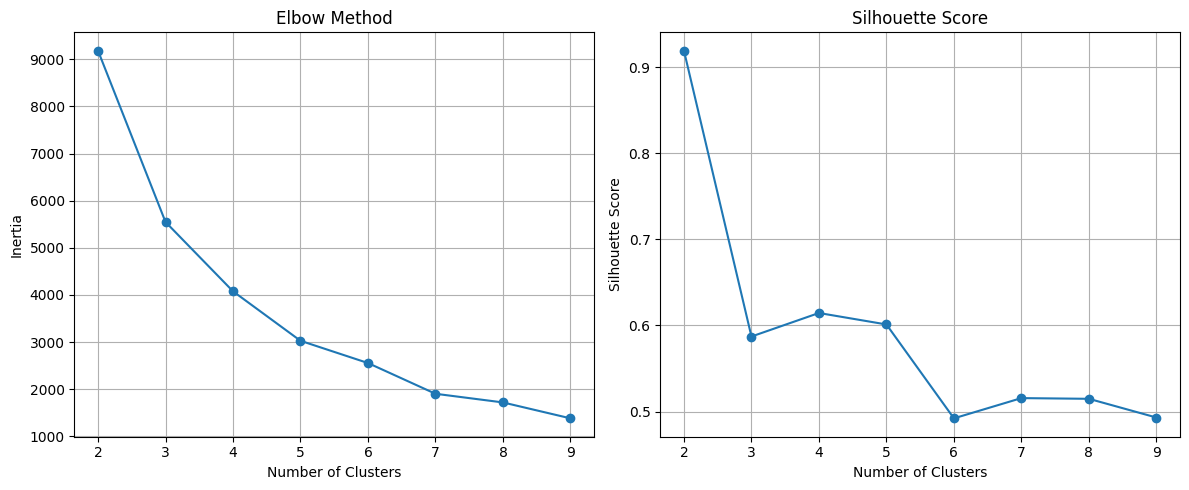

In [180]:
# Elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 10)
inertia = []
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(customer_RFM_scaled)

    inertia.append(kmeans.inertia_)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(customer_RFM_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.tight_layout()
plt.show()

### Inferences

**Elbow: k between 4 and 5:** The inertia drops sharply from k = 2 to k = 4, and then begins to flatten from k = 5 onward. The point where the inertia starts to diminish at a slower rate is around k = 4 or 5. This suggests that the optimal number of clusters is likely between 4 and 5, as adding more clusters beyond this point yields smaller improvements.

**Silhouette: k = 3 clearly wins:** Among higher values, k = 4 has the next highest silhouette score, indicating relatively well-separated and cohesive clusters. After k = 4, the silhouette score declines, showing reduced clustering quality.

Although k = 2 gives the highest silhouette score, a choice of k = 4 provides a strong balance between cluster cohesion and model complexity. 4 clusters is the best option for a RFM Segmentation.

## Applying Clustering KMeans

In [181]:
from collections import Counter

kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans.fit(customer_RFM_scaled)

cluster_frequencies = Counter(kmeans.labels_)

freq_sorted = cluster_frequencies.most_common()

label_mapping = {old_label: new_label for new_label, (old_label, _) in enumerate(freq_sorted)}

original_labels = kmeans.labels_                    # array([2, 0, 3, 3, 1, ...])
new_labels = np.array([label_mapping[label] for label in original_labels])

customer_RFM_scaled['cluster'] = new_labels
customer_data_cleaned['cluster'] = new_labels

customer_data_cleaned.head()

,CustomerID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,cluster
0,12346.0,325,2,0,0.00,0.000000,1,1.0,0.5,0.000000,0.000000,1
1,12347.0,1,7,2458,4310.00,615.714286,103,0.0,0.0,615.714286,341.070789,0
2,12348.0,74,4,2332,1437.24,359.310000,21,0.0,0.0,359.310000,203.875689,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.0,0.0,1457.550000,0.000000,0
4,12350.0,309,1,196,294.40,294.400000,16,0.0,0.0,294.400000,0.000000,1


In [182]:
print(customer_data_cleaned['cluster'].value_counts().sort_index())

cluster
0    3071
1    1073
2     207
3      11
Name: count, dtype: int64


In [183]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

features = customer_RFM_scaled.values

kmeans_silhouette = silhouette_score(features, kmeans.labels_)
kmeans_calinski = calinski_harabasz_score(features, kmeans.labels_)
kmeans_davies = davies_bouldin_score(features, kmeans.labels_)

print("K-Means Clustering Metrics:")
print("Silhouette Score K-Means:", kmeans_silhouette)
print("Calinski-Harabasz Score K-Means:", kmeans_calinski)
print("Davies-Bouldin Score K-Means:", kmeans_davies)

K-Means Clustering Metrics:
Silhouette Score K-Means: 0.6757703128490342
Calinski-Harabasz Score K-Means: 3732.4828701170163
Davies-Bouldin Score K-Means: 0.7266546820394173


### Evaluation Metrics

- **Silhouette Score (0.6758):** A value close to 0.68 suggests well-defined clusters with good cohesion and separation. This indicates a reliable clustering structure.
- **Calinski-Harabasz Score (3732.48):** A high score, reinforcing that the clusters are dense and well-separated.
- **Davies-Bouldin Score (0.7267):** A relatively low value, confirming that clusters are distinct and not overlapping excessively.

In [184]:
print("Mean values of each cluster:")
print(customer_data_cleaned.groupby('cluster')[['Recency', 'Total_Transactions', 'Total_Spend']].mean())

Mean values of each cluster:
            Recency  Total_Transactions    Total_Spend
cluster                                               
0         41.926083            4.260501    1299.026864
1        248.568500            1.778192     457.803374
2         10.536232           27.101449   11667.639469
3          4.090909          107.181818  124411.730909


In [185]:
customer_data_cleaned.rename(columns={'cluster': 'RFM'}, inplace=True)
customer_RFM_scaled.rename(columns={'cluster': 'RFM'}, inplace=True)

cluster_percentages = customer_data_cleaned['RFM'].value_counts(normalize=True) * 100
cluster_percentages

,proportion
RFM,
0,70.403485
1,24.598808
2,4.745530
3,0.252178


In [186]:
cluster_map = {
    0: 'Regular',
    1: 'Passenger',
    2: 'Loyal',
    3: 'Champion'
}

customer_RFM_scaled['RFM'] = customer_RFM_scaled['RFM'].map(cluster_map)
customer_data_cleaned['RFM'] = customer_data_cleaned['RFM'].map(cluster_map)

customer_data_cleaned.head(10)

,CustomerID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,RFM
0,12346.0,325,2,0,0.00,0.000000,1,1.0,0.500,0.000000,0.000000,Passenger
1,12347.0,1,7,2458,4310.00,615.714286,103,0.0,0.000,615.714286,341.070789,Regular
2,12348.0,74,4,2332,1437.24,359.310000,21,0.0,0.000,359.310000,203.875689,Regular
3,12349.0,18,1,630,1457.55,1457.550000,72,0.0,0.000,1457.550000,0.000000,Regular
4,12350.0,309,1,196,294.40,294.400000,16,0.0,0.000,294.400000,0.000000,Passenger
5,12352.0,35,8,463,1265.41,158.176250,57,1.0,0.125,316.352500,134.700629,Regular
6,12353.0,203,1,20,89.00,89.000000,4,0.0,0.000,89.000000,0.000000,Passenger
7,12354.0,231,1,530,1079.40,1079.400000,58,0.0,0.000,1079.400000,0.000000,Passenger
8,12355.0,213,1,240,459.40,459.400000,13,0.0,0.000,459.400000,0.000000,Passenger
9,12356.0,22,3,1573,2487.43,829.143333,52,0.0,0.000,829.143333,991.462585,Regular




### Clusters Interpretation

- **Champion:** Very low recency (≈4 days), extremely high purchase frequency (107 transactions), and by far the highest total spend ($124,412). Despite being only **0.25%** of the customer base, they are the most valuable segment. Prioritize retention, exclusive offers, and high-touch service for them.

- **Loyal:** Low recency (10.5 days), high frequency (27 transactions), and strong spending ($11,668). They represent **4.75%** of customers and contribute significantly to revenue. Ideal for loyalty programs, cross-sells, and appreciation campaigns.

- **Regular:** Moderate recency (42 days), moderate frequency (4.26 transactions), and average total spend ($1,299). Comprising **70.40%** of customers, they are the core base. Focus on nurturing, upselling, and engagement strategies to elevate them.

- **Passenger:** High recency (249 days), low frequency (1.78 transactions), and low spending ($458). Making up **24.60%** of the base, they are at risk of churn. Use reactivation tactics such as special offers, reminders, or feedback requests.


## Adding Churn client to RFM Segmentation

It is important to detect clients that churned, we will consider a churned customer those with a Recency above 180 (almost 6 months).

This will bring the opportunity to identify customers who was loyal or Champion and now is a lost customer, those are really important customers to recover. Based on the results we consider to add news segmentations.

In [187]:
customer_data_cleaned['Churned'] = (customer_data_cleaned['Recency'] > 180).astype(int)

churn_percentage_per_cluster = (
    customer_data_cleaned.groupby('RFM')['Churned'].mean() * 100
).round(2)

print("Churned Customers Percentage by Cluster (RFM):")
print(churn_percentage_per_cluster)

Churned Customers Percentage by Cluster (RFM):
RFM
Champion      0.00
Loyal         0.97
Passenger    80.24
Regular       0.00
Name: Churned, dtype: float64


In [188]:
customer_data_cleaned.loc[customer_data_cleaned['Churned'] == 1, 'RFM'] = (
    'Churned ' + customer_data_cleaned.loc[customer_data_cleaned['Churned'] == 1, 'RFM']
)

churned_counts = customer_data_cleaned.groupby('RFM')['Churned'].sum()

customer_data_cleaned.drop(columns=['Churned'], inplace=True)

print("Churned Customers Count by Cluster (RFM):")
print(churned_counts)

Churned Customers Count by Cluster (RFM):
RFM
Champion               0
Churned Loyal          2
Churned Passenger    861
Loyal                  0
Passenger              0
Regular                0
Name: Churned, dtype: int64


In [189]:
print("Percentage of Customers in Each Segment:")
cluster_percentages = customer_data_cleaned['RFM'].value_counts(normalize=True) * 100
cluster_percentages

Percentage of Customers in Each Segment:


,proportion
RFM,
Regular,70.403485
Churned Passenger,19.738652
Passenger,4.860156
Loyal,4.699679
Champion,0.252178
Churned Loyal,0.045851


### Inferences

- Integrating churn analysis into the RFM segmentation adds valuable insight into customer retention, allowing for more precise and actionable marketing strategies.

- Customers with a recency greater than 180 days (approximately 6 months) are classified as **churned**.

- The original RFM segments have been enhanced with churn-specific labels, such as **Churned Passenger** and **Churned Loyal**, allowing for a more nuanced understanding of customer behavior.

- While no **Churned Regular** or **Churned Champion** customers were found in this dataset, these segments could emerge in future analyses as customer behavior evolves.

### **Updated Segmentation Overview:**

- **Churned Passenger (19.74%)**: A large group of inactive, low-value customers. These users are prime targets for reactivation campaigns to regain lost revenue.

- **Passenger (4.86%)**: Low-engagement customers who are still active but at risk of churning. Monitoring and low-effort engagement strategies may help retain them.

- **Regular (70.40%)**: The largest and most stable segment. They represent consistent engagement and should be maintained through continued value delivery.

- **Loyal (4.70%)**: Frequent and engaged buyers. Nurturing this group with loyalty rewards and personalized offers is key to retention.

- **Churned Loyal (0.05%)**: A small but high-potential segment. These previously loyal customers are worth win-back efforts due to their historical value.

- **Champion (0.25%)**: High-spending, highly engaged customers. Though a small segment, they provide outsized value and should be prioritized for premium service and exclusive offers.

By embedding churn status into the RFM framework, the business gains deeper visibility into customer lifecycles. This allows for:
- Strategic recovery of high-value churned customers.
- Proactive engagement with at-risk segments.
- Focused retention of stable, revenue-generating customers.


## Creating  Monthly Spend and Quantity per Customer

In [190]:
from datetime import datetime

df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

monthly_transactions = df.groupby(['CustomerID', 'Year', 'Month']) \
    .agg({'TotalPrice': 'sum', 'Quantity': 'sum'}).reset_index()

monthly_transactions['YearMonth'] = pd.to_datetime(monthly_transactions[['Year', 'Month']].assign(DAY=1))

monthly_transactions.rename(columns={'TotalPrice': 'Monthly_TotalPrice', 'Quantity': 'Monthly_Quantity'}, inplace=True)

df.drop(columns=['Year', 'Month'], inplace=True)
monthly_transactions.drop(columns=['Year', 'Month'], inplace=True)

customer_data_cleaned.to_csv('Customer_cleaned.csv', index=False)
df.to_csv('Transactions_cleaned.csv', index=False)
monthly_transactions.to_csv('Monthly_Transactions.csv', index=False)

## Conclusion

Throughout this analysis, we:

- Cleaned and prepared the dataset by addressing missing values, duplicates, stock code errors, cancelled transactions, zero unit prices, and by creating a `TotalPrice` feature.
- Engineered RFM variables and additional customer-specific features to enrich insights.

Key features created include:

- Recency: Days since last purchase.  
- Total_Transactions**, Total_Products_Purchased, Total_Spend: Indicators of engagement and value.  
- Average_Transaction_Value, Unique_Products_Purchased: Reflect purchase habits and diversity.  
- Cancellation_Frequency**, Cancellation_Rate: Track reliability and satisfaction.  
- Monthly_Spending_Mean/Std: Capture spending trends and variability.

Analysis steps:

- Performed correlation analysis and feature scaling.
- Determined the optimal number of clusters.
- Applied KMeans clustering using core RFM features to segment customers.
- Integrated churn analysis by flagging customers inactive for over 180 days.
- Exported the cleaned and enriched datasets for future use.

### Final Customer Dataset

Each customer is now described with behavioral metrics and a segmentation label combining their RFM profile and churn status.

| **Feature**                    | **Description**                                                                                      |
|--------------------------------|------------------------------------------------------------------------------------------------------|
| **Customer ID**                | Unique identifier for each customer.                                                                |
| **Recency**                    | Days since last purchase.                                                                           |
| **Total_Transactions**         | Total number of purchases.                                                                          |
| **Total_Products_Purchased**   | Total quantity bought.                                                                              |
| **Total_Spend**                | Total amount spent.                                                                                 |
| **Average_Transaction_Value**  | Average spend per transaction.                                                                      |
| **Unique_Products_Purchased**  | Number of distinct items purchased.                                                                 |
| **Cancellation_Frequency**     | Number of cancelled transactions.                                                                   |
| **Cancellation_Rate**          | Cancellation ratio.                                                                                 |
| **Monthly_Spending_Mean/Std**  | Average and variability of monthly spending.                                                        |
| **RFM**                        | Segmentation label derived from RFM and churn status (e.g. *Champion*, *Churned Loyal*).             |

### RFM Segmentation Overview

| **Segment**           | **Share**   | **Description**                                                                                 |
|-----------------------|-------------|-------------------------------------------------------------------------------------------------|
| **Churned Passenger** | 19.74%      | Low-value, inactive customers. Target for reactivation campaigns.                              |
| **Passenger**         | 4.86%       | At-risk, low-engagement customers. Monitor and engage lightly.                                 |
| **Regular**           | 70.40%      | Core customer base with steady activity. Focus on retention.                                   |
| **Loyal**             | 4.70%       | High-engagement, frequent buyers. Reward and nurture.                                          |
| **Churned Loyal**     | 0.05%       | Previously valuable customers. Worth targeted win-back efforts.                                |
| **Champion**          | 0.25%       | Top-spending, most engaged customers. Prioritize with exclusive offers.                        |


This segmentation provides actionable insights into customer behavior and value, enabling more effective marketing, personalized retention strategies, and a better understanding of the customer base.
